,Congestión (prom),Congestión (±err),Atraso (prom min),Atraso (±err),Desvíos (prom),Desvíos (±err)
λ,,,,,,
0.02,0.001209,1.037557e-04,0.300016,0.029008,0.000000,0.000000e+00
0.10,0.006724,1.282658e-04,2.249862,0.054880,0.066895,2.837183e-03
0.20,0.013798,1.093118e-04,3.616569,0.054717,0.314622,3.638873e-03
0.50,0.022005,8.061369e-05,0.798532,0.029074,0.689561,1.129970e-03
1.00,0.036684,6.938894e-19,0.000000,0.000000,0.802778,1.110223e-17


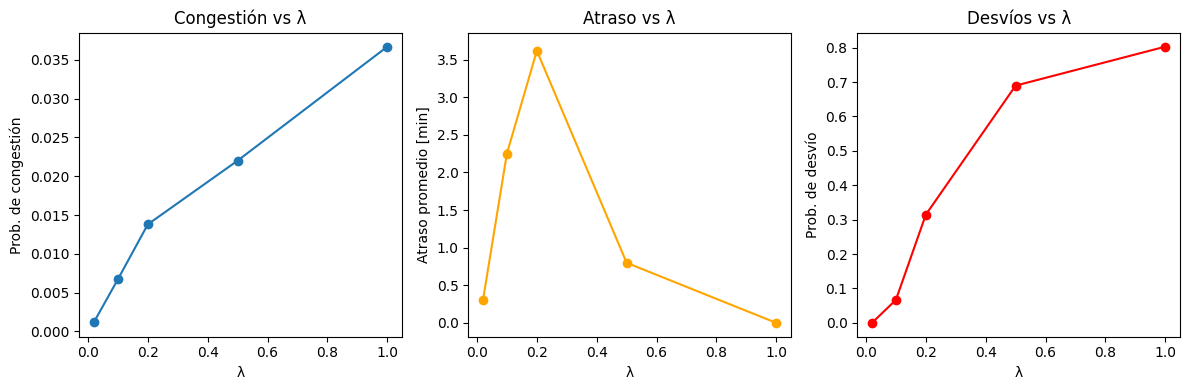

In [1]:
# simulacion_tp1.ipynb
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from main import Simulador  

# =========================
# Configuración
# =========================
LAMBDAS = [0.02, 0.1, 0.2, 0.5, 1.0]
N_SIM = 100   # número de réplicas Monte Carlo (subí si querés más precisión)

# =========================
# Función para correr simulaciones
# =========================
def correr_montecarlo(lam, n_rep=N_SIM):
    congestion_counts = []
    atrasos = []
    desviados = []

    for _ in range(n_rep):
        sim = Simulador(seed=np.random.randint(0, 1_000_000))
        sim.simular_dia(lam)

        # --- congestión: % de ticks con algún avión ajustando/regresando
        cong_eventos = sum(1 for h in sim.historial if h["estado"] in ("AJUSTANDO", "REGRESANDO"))
        cong = cong_eventos / max(1, len(sim.historial))
        congestion_counts.append(cong)

        # --- atraso promedio
        atrasos_rep = [a.retraso for a in sim.finalizados if a.estado == "ATERRIZADO"]
        atrasos.append(np.mean(atrasos_rep) if atrasos_rep else 0)

        # --- desvíos
        desv = sum(1 for a in sim.aviones.values() if a.estado == "DESVIADO") / max(1, len(sim.aviones))
        desviados.append(desv)

    return {
        "cong_mean": np.mean(congestion_counts),
        "cong_std": np.std(congestion_counts) / np.sqrt(n_rep),
        "delay_mean": np.mean(atrasos),
        "delay_std": np.std(atrasos) / np.sqrt(n_rep),
        "div_mean": np.mean(desviados),
        "div_std": np.std(desviados) / np.sqrt(n_rep),
    }


# =========================
# Correr experimentos
# =========================
resultados = {}
for lam in LAMBDAS:
    resultados[lam] = correr_montecarlo(lam)

# =========================
# Mostrar resultados
# =========================
df = pd.DataFrame(resultados).T
df.index.name = "λ"
df.columns = [
    "Congestión (prom)", "Congestión (±err)",
    "Atraso (prom min)", "Atraso (±err)",
    "Desvíos (prom)", "Desvíos (±err)"
]
display(df)

# =========================
# Gráficos
# =========================
plt.figure(figsize=(12,4))

# Congestión
plt.subplot(1,3,1)
plt.errorbar(df.index, df["Congestión (prom)"], yerr=df["Congestión (±err)"], fmt='-o')
plt.xlabel("λ")
plt.ylabel("Prob. de congestión")
plt.title("Congestión vs λ")

# Atrasos
plt.subplot(1,3,2)
plt.errorbar(df.index, df["Atraso (prom min)"], yerr=df["Atraso (±err)"], fmt='-o', color="orange")
plt.xlabel("λ")
plt.ylabel("Atraso promedio [min]")
plt.title("Atraso vs λ")

# Desvíos
plt.subplot(1,3,3)
plt.errorbar(df.index, df["Desvíos (prom)"], yerr=df["Desvíos (±err)"], fmt='-o', color="red")
plt.xlabel("λ")
plt.ylabel("Prob. de desvío")
plt.title("Desvíos vs λ")

plt.tight_layout()
plt.show()
